# Кредитный скоринг
## Задача:  
    Необходимо решить задачу кредитного скоринга клиентов Альфа-Банка, используя только данные кредитных историй.

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from category_encoders.count import CountEncoder as ce_CountEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


RANDOM_SEED = 100
TEST_SIZE = 0.3

# Загрузка данных

**Описание полей**

- id - Идентификатор заявки. Заявки пронумерованы так, что большему номеру соответствует более поздняя дата заявки.
- rn - Порядковый номер кредитного продукта в кредитной истории. Большему номеру соответствует продукт с более поздней датой открытия.
- pre_since_opened - Дней с даты открытия кредита до даты сбора данных (бинаризовано*)
- pre_since_confirmed - Дней с даты подтверждения информации по кредиту до даты сбора данных (бинаризовано*)
- pre_pterm - Плановое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
- pre_fterm	- Фактическое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
- pre_till_pclose - Плановое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
- pre_till_fclose - Фактическое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
- pre_loans_credit_limit - Кредитный лимит (бинаризовано*)
- pre_loans_next_pay_summ - Сумма следующего платежа по кредиту (бинаризовано*)
- pre_loans_outstanding - Оставшаяся невыплаченная сумма кредита (бинаризовано*)
- pre_loans_total_overdue - Текущая просроченная задолженность (бинаризовано*)
- pre_loans_max_overdue_sum - Максимальная просроченная задолженность (бинаризовано*)
- pre_loans_credit_cost_rate - Полная стоимость кредита (бинаризовано*)
- pre_loans5 - Число просрочек до 5 дней (бинаризовано*)
- pre_loans530 - Число просрочек от 5 до 30 дней (бинаризовано*)
- pre_loans3060 - Число просрочек от 30 до 60 дней (бинаризовано*)
- pre_loans6090 - Число просрочек от 60 до 90 дней (бинаризовано*)
- pre_loans90 - Число просрочек более, чем на 90 дней (бинаризовано*)
- is_zero_loans_5 - Флаг: нет просрочек до 5 дней
- is_zero_loans_530 - Флаг: нет просрочек от 5 до 30 дней
- is_zero_loans_3060 - Флаг: нет просрочек от 30 до 60 дней
- is_zero_loans_6090 - Флаг: нет просрочек от 60 до 90 дней
- is_zero_loans90 - Флаг: нет просрочек более, чем на 90 дней
- pre_util - Отношение оставшейся невыплаченной суммы кредита к кредитному лимиту (бинаризовано*)
- pre_over2limit - Отношение текущей просроченной задолженности к кредитному лимиту (бинаризовано*)
- pre_maxover2limit - Отношенение максимальной просроченной задолженности к кредитному лимиту (бинаризовано*)
- is_zero_util - Флаг: отношение оставшейся невыплаченной суммы кредита к кредитному лимиту равняется 0
- is_zero_over2limit - Флаг: отношение текущей просроченной задолженности к кредитному лимиту равняется 0
- is_zero_maxover2limit - Флаг: отношение максимальной просроченной задолженности к кредитному лимиту равняется 0
- enc_paym_{0..N} - Статусы ежемесячных платежей за последние N месяцев (закодировано**)
- enc_loans_account_holder_type - Тип отношения к кредиту (закодировано**)
- enc_loans_credit_status - Статус кредита (закодировано**)
- enc_loans_account_cur - Валюта кредита (закодировано**)
- enc_loans_credit_type - Тип кредита (закодировано**)
- pclose_flag - Флаг: плановое количество дней с даты открытия кредита до даты закрытия не определено 
- fclose_flag - Флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено
- flag - Целевая переменная, 1 – факт ухода в дефолт. Доступна участникам в обучающей выборке.

\* область значений поля разбивается на N непересекающихся промежутков, каждому промежутку случайным образом ставится в соответствие уникальный номер от 0 до N-1, значение поля  
\** каждому уникальному значению поля случайным образом ставится в соответствие уникальный номер от 0 до K, значение поля заменяется номером этого значения

In [2]:
def data_import(url_data, url_target_data):
    df_features = pd.read_parquet(url_data)
    df_target = pd.read_csv(url_target_data)
    df = df_features.merge(df_target[["id", "flag"]], how="outer", on="id")
    df = df.loc[df["rn"].notnull()]
    df.rename(columns={"flag": "target"}, inplace=True)
    return df   

df = data_import("train_data/train_data_0.pq", "train_target.csv")
df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,target
0,0,1.0,18.0,9.0,2.0,3.0,16.0,10.0,11.0,3.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
1,0,2.0,18.0,9.0,14.0,14.0,12.0,12.0,0.0,3.0,...,0.0,0.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
2,0,3.0,18.0,9.0,4.0,8.0,1.0,11.0,11.0,0.0,...,0.0,0.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,0
3,0,4.0,4.0,1.0,9.0,12.0,16.0,7.0,12.0,2.0,...,3.0,3.0,4.0,1.0,3.0,1.0,1.0,0.0,0.0,0
4,0,5.0,5.0,12.0,15.0,2.0,11.0,12.0,10.0,2.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0


In [3]:
df.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [4]:
df.shape

(1974724, 62)

In [8]:
df.isna().sum()

id                       0
rn                       0
pre_since_opened         0
pre_since_confirmed      0
pre_pterm                0
                        ..
enc_loans_credit_type    0
enc_loans_account_cur    0
pclose_flag              0
fclose_flag              0
target                   0
Length: 62, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1974724 entries, 0 to 1974723
Data columns (total 62 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   rn                             float64
 2   pre_since_opened               float64
 3   pre_since_confirmed            float64
 4   pre_pterm                      float64
 5   pre_fterm                      float64
 6   pre_till_pclose                float64
 7   pre_till_fclose                float64
 8   pre_loans_credit_limit         float64
 9   pre_loans_next_pay_summ        float64
 10  pre_loans_outstanding          float64
 11  pre_loans_total_overdue        float64
 12  pre_loans_max_overdue_sum      float64
 13  pre_loans_credit_cost_rate     float64
 14  pre_loans5                     float64
 15  pre_loans530                   float64
 16  pre_loans3060                  float64
 17  pre_loans6090                  float64
 18  pr

# Обработка данных

In [10]:
df = df.drop("id", axis=1)

In [11]:
df.columns

Index(['rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 'enc_p

In [15]:
df["rn"].describe()

count    1.974724e+06
mean     6.537471e+00
std      5.121167e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      9.000000e+00
max      5.100000e+01
Name: rn, dtype: float64

In [35]:
df.rn.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.])

In [31]:
df.rn.value_counts()

1.0     250000
2.0     229328
3.0     207951
4.0     186175
5.0     165023
6.0     145245
7.0     126275
8.0     108898
9.0      93532
10.0     79791
11.0     67690
12.0     57149
13.0     48190
14.0     40472
15.0     34053
16.0     28294
17.0     23211
18.0     18855
19.0     15031
20.0     11934
21.0      9309
22.0      7203
23.0      5495
24.0      4127
25.0      3102
26.0      2290
27.0      1696
28.0      1254
29.0       910
30.0       668
31.0       489
32.0       358
33.0       248
34.0       162
35.0        97
36.0        70
37.0        49
38.0        27
39.0        20
40.0        16
41.0        10
42.0         8
43.0         7
44.0         3
45.0         2
46.0         2
47.0         1
48.0         1
49.0         1
50.0         1
51.0         1
Name: rn, dtype: int64

In [86]:
plot_df = pd.DataFrame(df.rn.value_counts())
plot_df["id"] = plot_df.index
plot_df["id"] = plot_df["id"].astype("string")

In [87]:
def hist_plot(x, y):
    fig, bar_axes = plt.subplots(figsize=(26,6))
    bar_axes.set_title("Диаграмма")   # Задать заголовок графика
    bar_axes.set_ylabel("y_label")          # Задать зоголовок для оси y
    bar_axes.set_xlabel("x_label")          # Задать зоголовок для оси x
    bar1 = bar_axes.bar(x, y, 0.55, label="Column")
    bar_axes.set_xticks(x)
    bar_axes.bar_label(bar1, padding=3)
    bar_axes.legend()          # Включить наименование графиков
    plt.show()

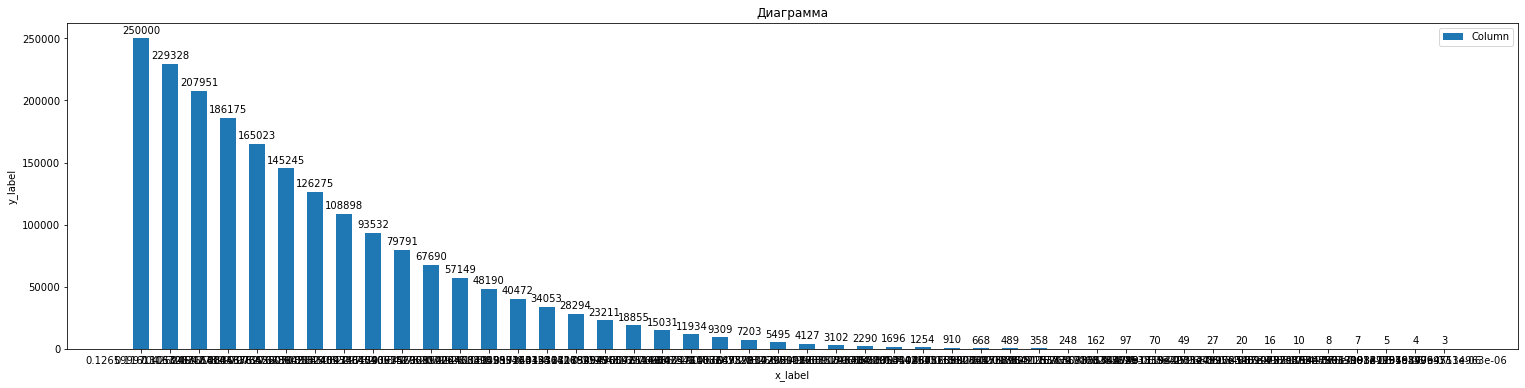

In [88]:
hist_plot(plot_df["id"], plot_df["rn"])

## Кодирование категориальных признаков

In [85]:
df["rn"] = df["rn"].astype("string")
fe = df.groupby("rn").size()/len(df)
df.loc[:, "rn"] = df["rn"].map(fe)
df

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,target,rn_freq_encode
0,0.126600,18.0,9.0,2.0,3.0,16.0,10.0,11.0,3.0,3.0,...,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0,0.126600
1,0.116132,18.0,9.0,14.0,14.0,12.0,12.0,0.0,3.0,3.0,...,0.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0,0.116132
2,0.105306,18.0,9.0,4.0,8.0,1.0,11.0,11.0,0.0,5.0,...,0.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,0,0.105306
3,0.094279,4.0,1.0,9.0,12.0,16.0,7.0,12.0,2.0,3.0,...,3.0,4.0,1.0,3.0,1.0,1.0,0.0,0.0,0,0.094279
4,0.083568,5.0,12.0,15.0,2.0,11.0,12.0,10.0,2.0,3.0,...,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0,0.083568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,0.094279,1.0,9.0,14.0,8.0,10.0,11.0,8.0,4.0,2.0,...,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0,0.094279
1974720,0.083568,7.0,9.0,4.0,8.0,1.0,11.0,19.0,1.0,4.0,...,3.0,4.0,1.0,2.0,4.0,1.0,1.0,1.0,0,0.083568
1974721,0.126600,9.0,0.0,10.0,8.0,10.0,11.0,16.0,2.0,3.0,...,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0,0.126600
1974722,0.116132,9.0,16.0,10.0,13.0,10.0,4.0,12.0,2.0,3.0,...,3.0,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0,0.116132


,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,target,rn_freq_encode
0,1.0,18.0,9.0,2.0,3.0,16.0,10.0,11.0,3.0,3.0,...,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0,0.126600
1,2.0,18.0,9.0,14.0,14.0,12.0,12.0,0.0,3.0,3.0,...,0.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0,0.116132
2,3.0,18.0,9.0,4.0,8.0,1.0,11.0,11.0,0.0,5.0,...,0.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,0,0.105306
3,4.0,4.0,1.0,9.0,12.0,16.0,7.0,12.0,2.0,3.0,...,3.0,4.0,1.0,3.0,1.0,1.0,0.0,0.0,0,0.094279
4,5.0,5.0,12.0,15.0,2.0,11.0,12.0,10.0,2.0,3.0,...,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0,0.083568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,4.0,1.0,9.0,14.0,8.0,10.0,11.0,8.0,4.0,2.0,...,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0,0.094279
1974720,5.0,7.0,9.0,4.0,8.0,1.0,11.0,19.0,1.0,4.0,...,3.0,4.0,1.0,2.0,4.0,1.0,1.0,1.0,0,0.083568
1974721,1.0,9.0,0.0,10.0,8.0,10.0,11.0,16.0,2.0,3.0,...,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0,0.126600
1974722,2.0,9.0,16.0,10.0,13.0,10.0,4.0,12.0,2.0,3.0,...,3.0,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0,0.116132


In [81]:

ce_CountEncoder2 = ce_CountEncoder(normalize=True)
df["rn"] = ce_CountEncoder2.fit_transform(df["rn"])
df

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,target
0,1.0,18.0,9.0,2.0,3.0,16.0,10.0,11.0,3.0,3.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
1,2.0,18.0,9.0,14.0,14.0,12.0,12.0,0.0,3.0,3.0,...,0.0,0.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
2,3.0,18.0,9.0,4.0,8.0,1.0,11.0,11.0,0.0,5.0,...,0.0,0.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,0
3,4.0,4.0,1.0,9.0,12.0,16.0,7.0,12.0,2.0,3.0,...,3.0,3.0,4.0,1.0,3.0,1.0,1.0,0.0,0.0,0
4,5.0,5.0,12.0,15.0,2.0,11.0,12.0,10.0,2.0,3.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,4.0,1.0,9.0,14.0,8.0,10.0,11.0,8.0,4.0,2.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0
1974720,5.0,7.0,9.0,4.0,8.0,1.0,11.0,19.0,1.0,4.0,...,3.0,3.0,4.0,1.0,2.0,4.0,1.0,1.0,1.0,0
1974721,1.0,9.0,0.0,10.0,8.0,10.0,11.0,16.0,2.0,3.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0
1974722,2.0,9.0,16.0,10.0,13.0,10.0,4.0,12.0,2.0,3.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0


In [49]:
df

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,target
0,0,1.0,18.0,9.0,2.0,3.0,16.0,10.0,11.0,3.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
1,0,2.0,18.0,9.0,14.0,14.0,12.0,12.0,0.0,3.0,...,0.0,0.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
2,0,3.0,18.0,9.0,4.0,8.0,1.0,11.0,11.0,0.0,...,0.0,0.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,0
3,0,4.0,4.0,1.0,9.0,12.0,16.0,7.0,12.0,2.0,...,3.0,3.0,4.0,1.0,3.0,1.0,1.0,0.0,0.0,0
4,0,5.0,5.0,12.0,15.0,2.0,11.0,12.0,10.0,2.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,249998,4.0,1.0,9.0,14.0,8.0,10.0,11.0,8.0,4.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0
1974720,249998,5.0,7.0,9.0,4.0,8.0,1.0,11.0,19.0,1.0,...,3.0,3.0,4.0,1.0,2.0,4.0,1.0,1.0,1.0,0
1974721,249999,1.0,9.0,0.0,10.0,8.0,10.0,11.0,16.0,2.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0
1974722,249999,2.0,9.0,16.0,10.0,13.0,10.0,4.0,12.0,2.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0


In [53]:
df

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,target
0,0,1.0,18.0,9.0,2.0,3.0,16.0,10.0,11.0,3.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
1,0,2.0,18.0,9.0,14.0,14.0,12.0,12.0,0.0,3.0,...,0.0,0.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
2,0,3.0,18.0,9.0,4.0,8.0,1.0,11.0,11.0,0.0,...,0.0,0.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,0
3,0,4.0,4.0,1.0,9.0,12.0,16.0,7.0,12.0,2.0,...,3.0,3.0,4.0,1.0,3.0,1.0,1.0,0.0,0.0,0
4,0,5.0,5.0,12.0,15.0,2.0,11.0,12.0,10.0,2.0,...,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,249998,4.0,1.0,9.0,14.0,8.0,10.0,11.0,8.0,4.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0
1974720,249998,5.0,7.0,9.0,4.0,8.0,1.0,11.0,19.0,1.0,...,3.0,3.0,4.0,1.0,2.0,4.0,1.0,1.0,1.0,0
1974721,249999,1.0,9.0,0.0,10.0,8.0,10.0,11.0,16.0,2.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0
1974722,249999,2.0,9.0,16.0,10.0,13.0,10.0,4.0,12.0,2.0,...,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0


In [3]:
df = df.drop("id", axis=1)
Y = df["target"]
X = df.drop("target", axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True)

# Cтроим модель

In [57]:
Log_model = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, Y_train)

y_pred_train = Log_model.predict(X_train)
y_pred_test = Log_model.predict(X_test)


acu_train = accuracy_score(y_pred_train, Y_train)
precision_train = precision_score(y_pred_train, Y_train)
recall_train = recall_score(y_pred_train, Y_train)
##rocauc_train = roc_auc_score(y_pred_train, Y_train)

acu_test = accuracy_score(y_pred_test, Y_test)
precision_test = precision_score(y_pred_test, Y_test)
recall_test = recall_score(y_pred_test, Y_test)
#rocauc_test = roc_auc_score(y_pred_test, Y_test)


print("Accuracy train: %.3f" % acu_train)
print("Accuracy test: %.3f" % acu_test)

print("Precision train: %.3f" % precision_train)
print("Precision test: %.3f" % precision_test)

print("Recall train: %.3f" % recall_train)
print("Recall test: %.3f" % recall_test)

#print("ROCAUC train: %.3f" % rocauc_train)
#print("ROCAUC test: %.3f" % rocauc_test)

/home/roman/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/roman/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy train: 0.971
Accuracy test: 0.971
Precision train: 0.000
Precision test: 0.000
Recall train: 0.000
Recall test: 0.000


/home/roman/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
Rforest_model = RandomForestClassifier(max_depth=10, random_state=RANDOM_SEED).fit(X_train, Y_train)

y_pred_train = Rforest_model.predict(X_train)
y_pred_test = Rforest_model.predict(X_test)


acu_train = accuracy_score(y_pred_train, Y_train)
precision_train = precision_score(y_pred_train, Y_train)
recall_train = recall_score(y_pred_train, Y_train)
rocauc_train = roc_auc_score(y_pred_train, Y_train)

acu_test = accuracy_score(y_pred_test, Y_test)
precision_test = precision_score(y_pred_test, Y_test)
recall_test = recall_score(y_pred_test, Y_test)
rocauc_test = roc_auc_score(y_pred_test, Y_test)


print("Accuracy train: %.3f" % acu_train)
print("Accuracy test: %.3f" % acu_test)

print("Precision train: %.3f" % precision_train)
print("Precision test: %.3f" % precision_test)

print("Recall train: %.3f" % recall_train)
print("Recall test: %.3f" % recall_test)

print("ROCAUC train: %.3f" % rocauc_train)
print("ROCAUC test: %.3f" % rocauc_test)

/home/roman/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

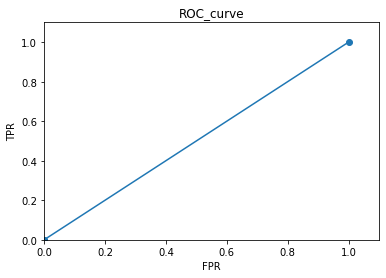

In [12]:
fprs, tprs, thr = roc_curve(Y_test, y_pred_test)

plt.plot(fprs, tprs, marker='o')
plt.ylim([0, 1.1]);plt.xlim([0, 1.1])
plt.xlabel('FPR');plt.ylabel('TPR')
plt.title('ROC_curve');

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.625


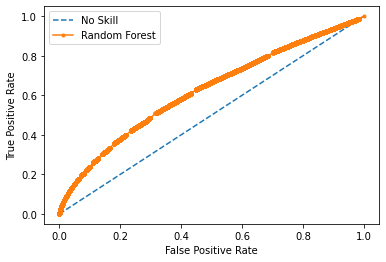

In [5]:

ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = Rforest_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

array([0, 0, 0, ..., 0, 0, 0])